--- 1. Data Splitting Complete ---
Original Training Set Class Distribution:
kdigo_aki
1    14310
0     4797
Name: count, dtype: int64

--- 2. Scaling and Imputation Complete ---

--- 3. Augmenting Training Data ---
Original class distribution: {1: 14310, 0: 4797}
Majority class: 1 (count: 14310)
Minority class: 0 (count: 4797)
Generating 4756 samples with SMOTE...


c:\Users\vamsi\anaconda3\envs\rl_med_diag\lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



Training CTGAN on 4797 original minority samples to generate 4757 new samples...


c:\Users\vamsi\anaconda3\envs\rl_med_diag\lib\site-packages\sdv\single_table\base.py:163: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

c:\Users\vamsi\anaconda3\envs\rl_med_diag\lib\site-packages\sdv\single_table\base.py:129: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.




Combining original, SMOTE-augmented, and GAN-generated data...

Final Augmented Training Set Class Distribution:
kdigo_aki
0    14310
1    14310
Name: count, dtype: int64


C:\Users\vamsi\AppData\Local\Temp\ipykernel_38000\3661719326.py:153: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\vamsi\AppData\Local\Temp\ipykernel_38000\3661719326.py:157: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\vamsi\AppData\Local\Temp\ipykernel_38000\3661719326.py:160: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\vamsi\AppData\Local\Temp\ipykernel_38000\3661719326.py:163: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



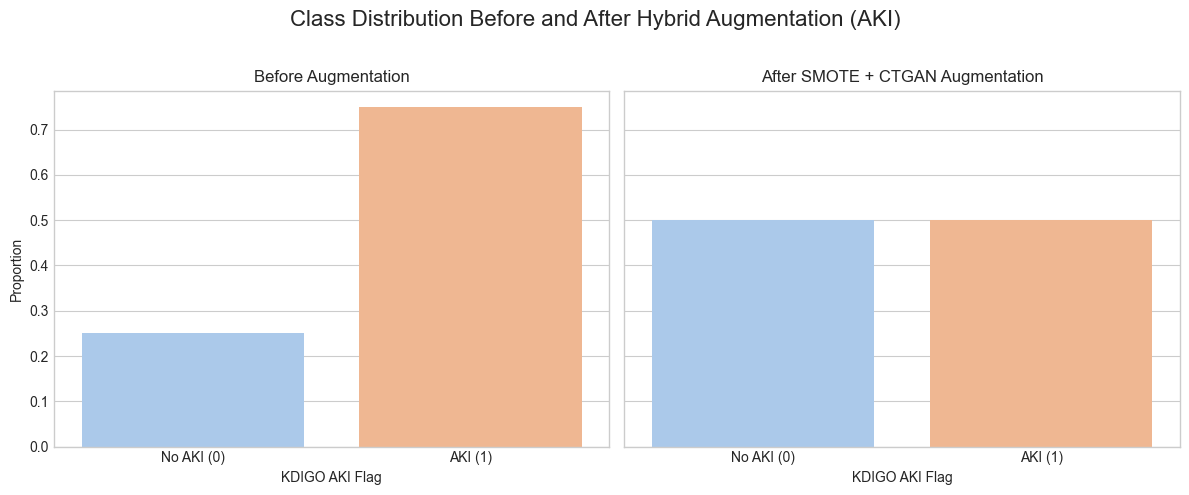

In [7]:
"""
AKI Data Augmentation Test (v1.2 - Final Fix)

This notebook tests the full data preparation pipeline on the AKI dataset.
This version contains a more robust data augmentation logic to fix the
recurring SMOTE ValueError.

The final output is a verification of the balanced dataset and a bar chart
visualizing the class balance before and after augmentation.
"""
# --- 1. Setup ---
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer

# --- 2. Configuration for AKI ---
CONFIG = {
    "INPUT_FILE": "../data/preprocessed/aki_feature_matrix.csv",
    "OUTPUT_DIR": Path("../data/processed/aki/"),
    "TARGET_COLUMN": "kdigo_aki",
    "ID_COLUMNS": ['subject_id', 'hadm_id', 'stay_id'],
    "RANDOM_STATE": 42
}

# --- 3. The Main Pipeline Functions ---

def process_and_augment_data(config):
    """
    Runs the entire pipeline: load, split, scale, impute, and augment.
    """
    try:
        df = pd.read_csv(config["INPUT_FILE"])
    except FileNotFoundError:
        print(f"Error: Input file not found at '{config['INPUT_FILE']}'")
        return None, None

    # --- Splitting ---
    X = df.drop(columns=[config["TARGET_COLUMN"]])
    y = df[config["TARGET_COLUMN"]]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=config["RANDOM_STATE"], stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=config["RANDOM_STATE"], stratify=y_temp)
    
    original_distribution = y_train.value_counts(normalize=True)
    print("--- 1. Data Splitting Complete ---")
    print(f"Original Training Set Class Distribution:\n{y_train.value_counts()}")

    # --- Scaling and Imputation ---
    id_cols = [col for col in config["ID_COLUMNS"] if col in X_train.columns]
    feature_cols = [col for col in X_train.columns if col not in id_cols]
    
    scaler = StandardScaler()
    imputer = SimpleImputer(strategy='mean')
    
    X_train_processed = X_train.copy()
    X_train_processed[feature_cols] = scaler.fit_transform(X_train[feature_cols])
    X_train_processed[feature_cols] = imputer.fit_transform(X_train_processed[feature_cols])
    print("\n--- 2. Scaling and Imputation Complete ---")

    # --- Augmentation ---
    X_train_aug, y_train_aug = augment_training_data(X_train_processed, y_train, config)
    
    augmented_distribution = y_train_aug.value_counts(normalize=True)
    print(f"\nFinal Augmented Training Set Class Distribution:\n{y_train_aug.value_counts()}")
    
    return original_distribution, augmented_distribution

def augment_training_data(X_train_imputed, y_train, config):
    """
    Applies the hybrid SMOTE and CTGAN augmentation strategy using a more robust logic.
    """
    print("\n--- 3. Augmenting Training Data ---")
    
    id_cols = [col for col in config["ID_COLUMNS"] if col in X_train_imputed.columns]
    X_train_features = X_train_imputed.drop(columns=id_cols)
    
    # Get original class counts and identify majority/minority classes
    original_counts = y_train.value_counts()
    print(f"Original class distribution: {original_counts.to_dict()}")
    
    # Identify majority and minority classes
    if original_counts[0] > original_counts[1]:
        majority_class = 0
        minority_class = 1
        n_majority = original_counts[0]
        n_minority = original_counts[1]
    else:
        majority_class = 1
        minority_class = 0
        n_majority = original_counts[1]
        n_minority = original_counts[0]
    
    print(f"Majority class: {majority_class} (count: {n_majority})")
    print(f"Minority class: {minority_class} (count: {n_minority})")
    
    if n_minority == 0:
        print("No minority samples found, skipping augmentation.")
        return X_train_imputed, y_train
        
    num_to_generate = n_majority - n_minority
    num_from_smote = num_to_generate // 2
    num_from_gan = num_to_generate - num_from_smote
    
    # --- SMOTE ---
    print(f"Generating {num_from_smote} samples with SMOTE...")
    smote_strategy = {minority_class: n_minority + num_from_smote}
    smote = SMOTE(sampling_strategy=smote_strategy, random_state=config["RANDOM_STATE"])
    X_smote_interim, y_smote_interim = smote.fit_resample(X_train_features, y_train)
    
    # --- CTGAN ---
    original_minority_features = X_train_features[y_train == minority_class]
    print(f"Training CTGAN on {len(original_minority_features)} original minority samples to generate {num_from_gan} new samples...")
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=original_minority_features)
    ctgan = CTGANSynthesizer(metadata, epochs=300, verbose=False)
    ctgan.fit(original_minority_features)
    gan_generated_features = ctgan.sample(num_rows=num_from_gan)
    gan_generated_labels = pd.Series([minority_class] * num_from_gan, name=config["TARGET_COLUMN"])
    
    # --- Combine ---
    print("\nCombining original, SMOTE-augmented, and GAN-generated data...")
    X_smote_interim_df = pd.DataFrame(X_smote_interim, columns=X_train_features.columns)
    y_smote_interim_s = pd.Series(y_smote_interim, name=config["TARGET_COLUMN"])
    
    X_final = pd.concat([X_smote_interim_df, gan_generated_features], ignore_index=True)
    y_final = pd.concat([y_smote_interim_s, gan_generated_labels], ignore_index=True)
    
    # Shuffle the final combined data
    shuffled_indices = X_final.sample(frac=1, random_state=config["RANDOM_STATE"]).index
    X_train_aug = X_final.loc[shuffled_indices].reset_index(drop=True)
    y_train_aug = y_final.loc[shuffled_indices].reset_index(drop=True)
    
    return X_train_aug, y_train_aug

# --- 4. Run Pipeline and Get Distributions ---
original_dist, augmented_dist = process_and_augment_data(CONFIG)

# --- 5. Visualize Results for Proof ---
if original_dist is not None:
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    fig.suptitle('Class Distribution Before and After Hybrid Augmentation (AKI)', fontsize=16)

    # Before
    sns.barplot(x=original_dist.index, y=original_dist.values, ax=axes[0], palette='pastel')
    axes[0].set_title('Before Augmentation')
    axes[0].set_xlabel('KDIGO AKI Flag')
    axes[0].set_ylabel('Proportion')
    axes[0].set_xticklabels(['No AKI (0)', 'AKI (1)'])

    # After
    sns.barplot(x=augmented_dist.index, y=augmented_dist.values, ax=axes[1], palette='pastel')
    axes[1].set_title('After SMOTE + CTGAN Augmentation')
    axes[1].set_xlabel('KDIGO AKI Flag')
    axes[1].set_xticklabels(['No AKI (0)', 'AKI (1)'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
